In [1]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image, ImageEnhance
import numpy as np
import random
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import classification_report


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir = '/content/drive/My Drive/Colab Notebooks/braintumor'
train_dir = os.path.join(data_dir, 'Training')
test_dir = os.path.join(data_dir, 'Testing')

In [4]:
CATEGORIES = ['glioma', 'meningioma', 'notumor']
NUM_CATEGORIES = len(CATEGORIES)
NUM_CATEGORIES

3

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.RandomVerticalFlip(),
                                     transforms.RandomAdjustSharpness(sharpness_factor=1.5),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ColorJitter(),
                                     transforms.Resize((128,128))])

In [6]:
train_image_datasets = torchvision.datasets.ImageFolder(train_dir, transform=transform)
test_image_datasets = torchvision.datasets.ImageFolder(test_dir, transform=transform)
train_image_datasets, valid_image_datasets = random_split(train_image_datasets, [3617, 638])
len(train_image_datasets), len(valid_image_datasets), len(test_image_datasets)

(3617, 638, 1011)

In [7]:
batch_size = 128
train_dataloaders = torch.utils.data.DataLoader(train_image_datasets, batch_size=batch_size, shuffle=True, num_workers=2)
valid_dataloaders = torch.utils.data.DataLoader(valid_image_datasets, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataloaders = torch.utils.data.DataLoader(test_image_datasets, batch_size=batch_size, shuffle=True, num_workers=2)

In [8]:
directory = os.getcwd() + '\models'
if not os.path.exists(directory):
    os.makedirs(directory)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
def accuracy(output,labels):
    predictions = torch.argmax(output,dim=1)
    correct = (predictions == labels).sum().cpu().numpy()
    return correct / len(labels)

In [18]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [16]:
DenseNet121_model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg16', pretrained=True).to(device)
DenseNet121_model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 270MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
DenseNet121_model.classifier[6] = nn.Linear(4096,3)


In [18]:
DenseNet121_model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [19]:
num_epochs = 4
import torch.optim as optim
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(DenseNet121_model.parameters(), lr=0.001, momentum=0.9)

In [20]:
loss_train = []
accuracy_train = []
loss_validation = []
accuracy_validation = []
np.random.seed(0)
max_accuracy = 0
for epoch in range(num_epochs):
    DenseNet121_model.train()
    DenseNet121_model.to(device)
    criterion.to(device)
    running_loss = 0.0
    running_accuracy = 0.0
    for batch in tqdm(train_dataloaders):  
        image_batch, label_batch  = batch
        image_batch, label_batch = image_batch.to(device), label_batch
        label_batch = torch.flatten(label_batch).type(torch.LongTensor).to(device)
        # Forward pass
        outputs = DenseNet121_model(image_batch).to(device)
        loss = criterion(outputs, label_batch)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() 
        running_accuracy += accuracy(outputs, label_batch)

    print ('Epoch [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, running_loss / len(train_dataloaders),running_accuracy / len(train_dataloaders)))
    
    loss_train.append(running_loss / len(train_dataloaders))
    accuracy_train.append(running_accuracy / len(train_dataloaders))

    DenseNet121_model.eval()  
    running_accuracy_valid = []
    running_loss_valid = 0
    for itr,data in enumerate(valid_dataloaders):
                imgs = data[0].to(device)
                labels = data[1].to(device)   
                labels = torch.flatten(labels).type(torch.LongTensor).to(device)
                y_pred = DenseNet121_model(imgs).to(device)
                running_accuracy_valid.append(accuracy(y_pred,labels))
                running_loss_valid += loss.item()
    loss_val_ep =  running_loss_valid / len(test_dataloaders)
    acc_val_ep = np.mean(np.array(running_accuracy_valid))
    print(f'Validation accuracy - {acc_val_ep}')
    accuracy_validation.append(acc_val_ep)
    loss_validation.append(loss_val_ep)


    if np.mean(np.array(accuracy_validation)) > max_accuracy:
        max_accuracy = np.mean(np.array(accuracy_validation)) 
        torch.save(DenseNet121_model, directory+'\model_DenseNet121') 

<ipython-input-20-ddeac864c230>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dataloaders):


  0%|          | 0/29 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch [1/4], Loss: 0.6178


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Validation accuracy - 0.8870287698412698


  0%|          | 0/29 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch [2/4], Loss: 0.2843


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Validation accuracy - 0.945138888888889


  0%|          | 0/29 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch [3/4], Loss: 0.2066


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Validation accuracy - 0.945138888888889


  0%|          | 0/29 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch [4/4], Loss: 0.1612


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Validation accuracy - 0.9530505952380952


In [21]:
wghts = torch.load(directory + '\model_DenseNet121')
DenseNet121_model.load_state_dict(wghts.state_dict())

<All keys matched successfully>

In [22]:
DenseNet121_model.eval()
y_true_list = []
y_pred_list = []
correct = 0
total = 0
with torch.no_grad():
    for batch in test_dataloaders:
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch
        label_batch = torch.flatten(label_batch).type(torch.LongTensor).to(device)
        outputs = DenseNet121_model(image_batch).to(device)
        predicted = torch.argmax(outputs, dim=1)
        
        y_true_list.append(label_batch.to('cpu').numpy())
        y_pred_list.append(predicted.to('cpu').numpy())
        
        total += label_batch.size(0)
        correct += (predicted == label_batch).sum().item()


print(f"Точность модели на test: {100 * correct / total:.2f} %")

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Точность модели на test: 90.31 %


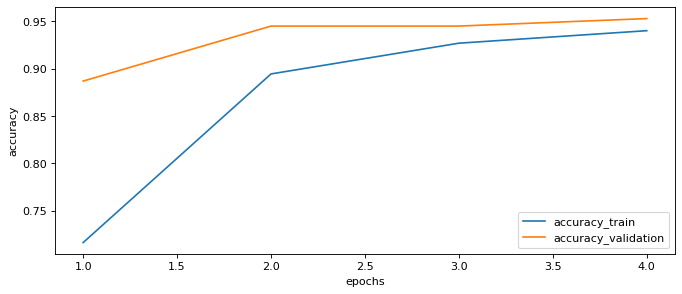

In [23]:
plt.figure(figsize=(10, 4), dpi=80)
plt.plot(list(range(1, num_epochs+1)), accuracy_train, label='accuracy_train')
plt.plot(list(range(1, num_epochs+1)), accuracy_validation, label='accuracy_validation')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

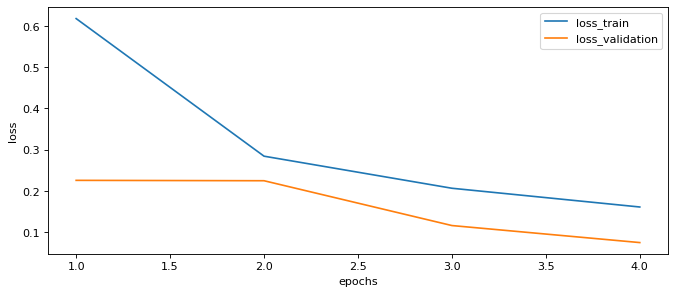

In [24]:
plt.figure(figsize=(10, 4), dpi=80)
plt.plot(list(range(1, num_epochs+1)), loss_train, label='loss_train')
plt.plot(list(range(1, num_epochs+1)), loss_validation, label='loss_validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()